In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import mean
from sklearn.metrics import mean_squared_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from matplotlib import pyplot
import warnings
import itertools

# Explore the Data

In [2]:
#Download file and get a look at the data
df = pd.read_csv(r"C:\Users\TE435942\J\Seaborn Cheatsheet\IPG2211A2N.csv")
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3298
1,1939-02-01,3.3552
2,1939-03-01,3.4315
3,1939-04-01,3.4569
4,1939-05-01,3.4569


In [3]:
df.dtypes

DATE           object
IPG2211A2N    float64
dtype: object

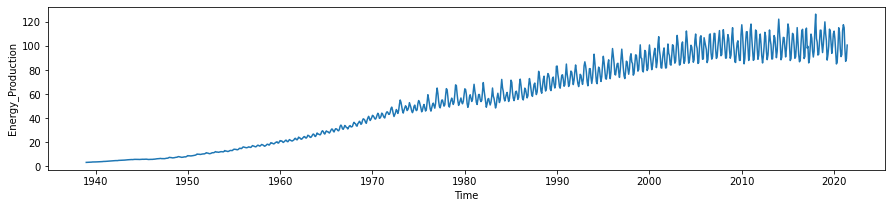

In [4]:
#Rename columns & transform date from object into datetime (datetime is required for forecasting libs)
df.rename(columns = {'IPG2211A2N':'Energy_Production', 'DATE':'Date'}, inplace = True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

#Plot Energy Production vs. Time
plt.figure(figsize=(15,3))
plt.plot(df['Date'],df['Energy_Production'])
plt.xlabel('Time')
plt.ylabel('Energy_Production')
plt.show()

In [5]:
#seasonal_decompose is a results class for seasonal composition
#attributes include number of observations (nobs), observed data (observed), estimated residuals (resid), estimated seasonal
#component (seasonal), estimated trend component (trend), and weights used in robust estimation (weights)
y_decompose = seasonal_decompose(df['Energy_Production'], model = 'additive', freq = 12)

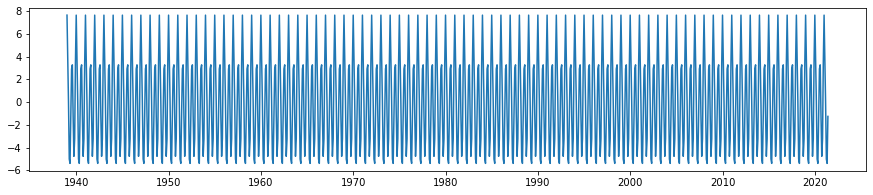

In [6]:
#Plot the seasonal component
plt.figure(figsize=(15,3))
seasonal = y_decompose.seasonal
plt.plot(df['Date'],seasonal)
plt.show()

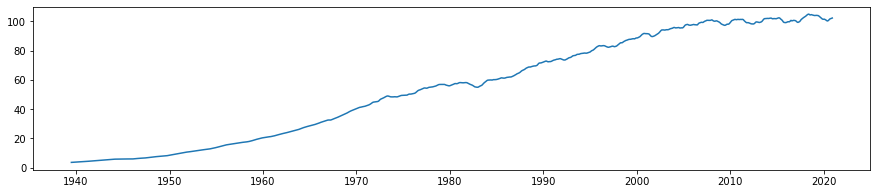

In [7]:
#Plot the Trend Component
plt.figure(figsize=(15,3))
trend = y_decompose.trend
plt.plot(df['Date'],trend)
plt.show()

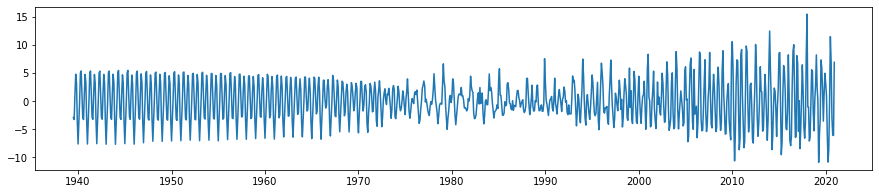

In [8]:
#Plot the residuals
plt.figure(figsize=(15,3))
resid = y_decompose.resid
plt.plot(df['Date'],resid)
plt.show()

In [9]:
#Confirm that the observed value is equal to the sum of the seasonal, trend, and residual components

observed_134 = y_decompose.observed[133]
seasonal_134 = y_decompose.seasonal[133]
trend_134 = y_decompose.trend[133]
resid_134 = y_decompose.resid[133]

sum_134 = seasonal_134 + trend_134 + resid_134

print(observed_134)
print(sum_134)

8.7439
8.7439


# Start the Forecasting

## Simple Moving Average (SMA)

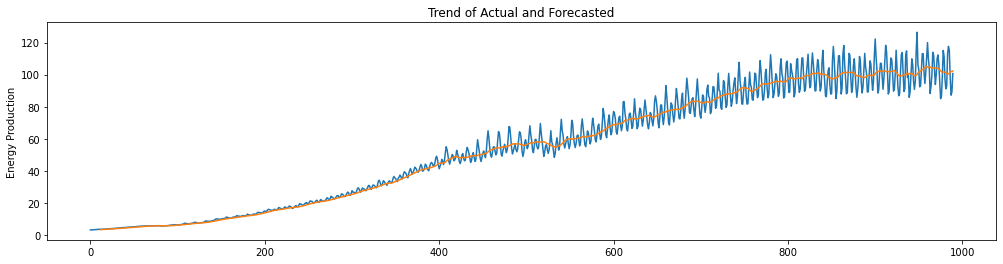

In [10]:
#Create a copy of df and add a column 'Moving Avg_12' which is the mean of the last 12 instances
df1 = df.copy()
df1['Moving Avg_12'] = df1['Energy_Production'].rolling(window=12).mean().shift(1)

plt.figure(figsize=(17,4))
plt.ylabel('Energy Production')
plt.title('Trend of Actual and Forecasted')
plt.plot(df1[['Energy_Production','Moving Avg_12']]);

In [11]:
#Let's evaluate the effectiveness of predicting with this method
def get_mape(actual, predicted):
    return np.round(np.mean(np.abs((actual-predicted) / actual))*100,2)

In [12]:
#On average, we're off by 8.37%
get_mape(df1['Energy_Production'][928:].values, df1['Moving Avg_12'][928:].values)

8.37

In [13]:
#On average we're off by 10.07 units of production
np.sqrt(mean_squared_error(df1['Energy_Production'][928:].values, df1['Moving Avg_12'][928:].values))

10.067899506857998

# Single Exponential Smoothing

In [14]:
fit1 = SimpleExpSmoothing(np.asarray(df1['Energy_Production'][:928].values)).fit()
fit1.summary()

Dep. Variable:,endog,No. Observations:,928
Model:,SimpleExpSmoothing,SSE,23838.539
Optimized:,True,AIC,3016.313
Trend:,None,BIC,3025.979
Seasonal:,None,AICC,3016.356
Seasonal Periods:,None,Date:,"Tue, 10 Aug 2021"
Box-Cox:,False,Time:,12:15:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,3.3295309,l.0,True


18.238956717477574
14.24


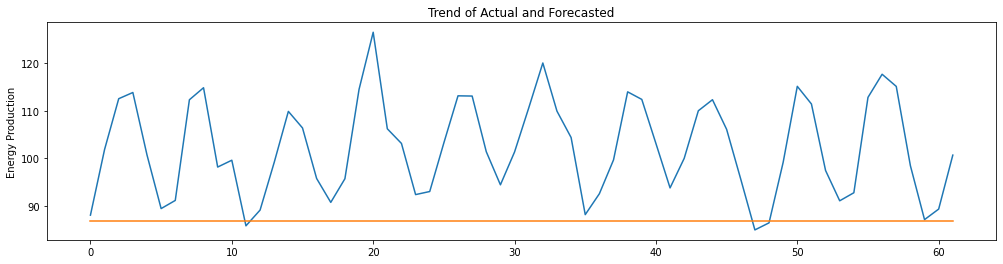

In [15]:
train_data = df1['Energy_Production'][:928]
test_data = df1['Energy_Production'][928:]
y_hat_avg = test_data.copy()
y_hat_avg['Single_Smoothed_Forecast'] = fit1.forecast(len(test_data))
rms = math.sqrt(mean_squared_error(test_data, y_hat_avg.Single_Smoothed_Forecast))
print(rms)
print(get_mape(test_data,y_hat_avg.Single_Smoothed_Forecast))

plt.figure(figsize=(17,4))
plt.ylabel('Energy Production')
plt.title('Trend of Actual and Forecasted')
plt.plot([x for x in range(len(test_data))],test_data,y_hat_avg['Single_Smoothed_Forecast'])
plt.show()

## Double Exponential Smoothing

In [16]:
fit2 = Holt(np.asarray(df1['Energy_Production'][:928].values)).fit()
fit2.summary()

Dep. Variable:,endog,No. Observations:,928
Model:,Holt,SSE,23868.898
Optimized:,True,AIC,3021.494
Trend:,Additive,BIC,3040.826
Seasonal:,None,AICC,3021.585
Seasonal Periods:,None,Date:,"Tue, 10 Aug 2021"
Box-Cox:,False,Time:,12:15:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9992179,alpha,True
smoothing_trend,0.0009924,beta,True


16.18080029761275
12.31


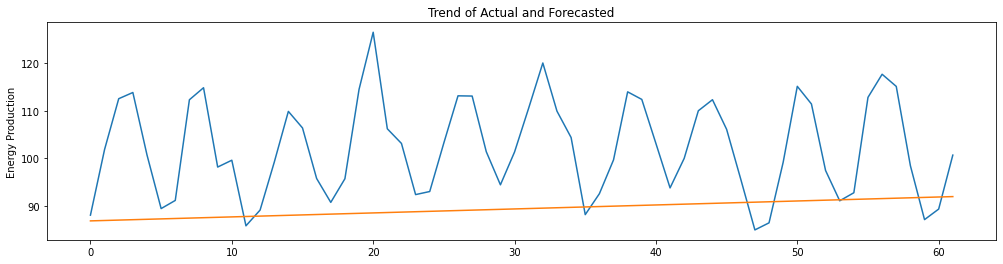

In [17]:
train_data = df1['Energy_Production'][:928]
test_data = df1['Energy_Production'][928:]
y_hat_avg = test_data.copy()
y_hat_avg['Double_Smoothed_Forecast'] = fit2.forecast(len(test_data))
rms = math.sqrt(mean_squared_error(test_data, y_hat_avg.Double_Smoothed_Forecast))
print(rms)
print(get_mape(test_data,y_hat_avg.Double_Smoothed_Forecast))

plt.figure(figsize=(17,4))
plt.ylabel('Energy Production')
plt.title('Trend of Actual and Forecasted')
plt.plot([x for x in range(len(test_data))],test_data,y_hat_avg['Double_Smoothed_Forecast'])
plt.show()

## Triple Exponential Smoothing

In [18]:
fit3 = ExponentialSmoothing(np.asarray(df1['Energy_Production'][:928].values), seasonal_periods=12 ,trend='add', seasonal='add',).fit()
fit3.summary()

Dep. Variable:,endog,No. Observations:,928
Model:,ExponentialSmoothing,SSE,2846.672
Optimized:,True,AIC,1072.171
Trend:,Additive,BIC,1149.500
Seasonal:,Additive,AICC,1072.924
Seasonal Periods:,12,Date:,"Tue, 10 Aug 2021"
Box-Cox:,False,Time:,12:15:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4086044,alpha,True
smoothing_trend,1.3195e-15,beta,True


RMS: 3.9815842634686573
MAPE: 3.27


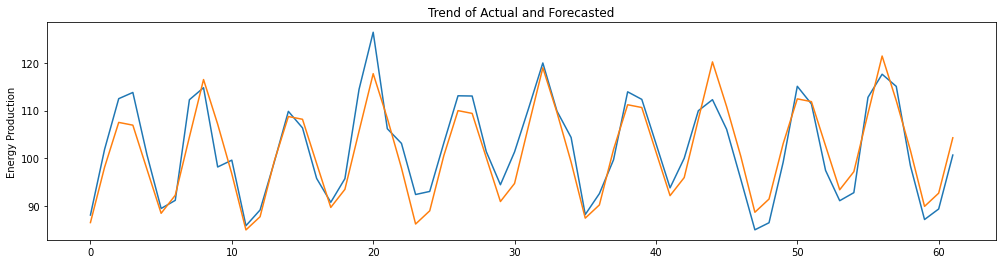

In [20]:
train_data = df1['Energy_Production'][:928]
test_data = df1['Energy_Production'][928:]
y_hat_avg = test_data.copy()
y_hat_avg['Triple_Smoothed_Forecast'] = fit3.forecast(len(test_data))
rms = math.sqrt(mean_squared_error(test_data, y_hat_avg.Triple_Smoothed_Forecast))
print("RMS: " + str(rms))
print("MAPE: " + str(get_mape(test_data,y_hat_avg.Triple_Smoothed_Forecast)))

plt.figure(figsize=(17,4))
plt.ylabel('Energy Production')
plt.title('Trend of Actual and Forecasted')
plt.plot([x for x in range(len(test_data))],test_data,y_hat_avg['Triple_Smoothed_Forecast'])
plt.show()